In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF
import time

In [ ]:
batch_size = 64
epochCount = 25
learningRate = 0.001

In [ ]:
batchrow = int(batch_size / 8)

In [ ]:
dataset_0 = torchvision.datasets.EMNIST(root='./data',split='balanced', train=True, download=True, transform=transforms.ToTensor())

dataloader = torch.utils.data.DataLoader(dataset_0, batch_size=10, num_workers=2, shuffle=False)

mean = 0.
std = 0.

for i, data in enumerate(dataloader, 0):
    img, lbl = data
    batchSize = img.size(0)
    img = img.view(batchSize, img.size(1), -1)
    mean += img.mean(2).sum(0)
    std += img.std(2).sum(0)
  
mean /= len(dataset_0)
std /= len(dataset_0)
print(mean, std)

tensor([0.1751]) tensor([0.3267])


In [ ]:
transforms = transforms.Compose(
    [lambda img: torchvision.transforms.functional.rotate(img, -90),
     lambda img: torchvision.transforms.functional.hflip(img),
     transforms.ToTensor(),
     transforms.Normalize((0.1751),(0.3267))])

dataset = torchvision.datasets.EMNIST(root='./data',split='balanced', train=True, download=True, transform=transforms)

trainset, valset = torch.utils.data.random_split(dataset, [94000, 18800])

testset = torchvision.datasets.EMNIST(root='./data',split='balanced', train=False, download=True, transform=transforms)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=int(batch_size / 5), shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
classes = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','d','e','f','g','h','n','q','r','t']

In [ ]:
print(len(trainset))
print(len(valset))
print(len(testset))
epoch_count_train = int(len(trainset) / batch_size)
epoch_count_val = int(5 * len(valset) / batch_size)
print(epoch_count_train)
print(epoch_count_val)

94000
18800
18800
1468
1468


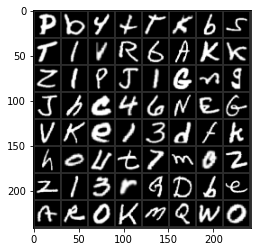

    P     b     Y     t     T     K     b     S

    T     1     V     R     6     A     K     K

    Z     1     P     J     I     G     n     g

    J     h     C     4     6     N     E     G

    V     K     e     L     3     d     f     K

    h     O     U     t     7     M     O     Z

    Z     1     3     r     G     D     b     e

    A     R     0     K     M     Q     W     O



In [ ]:
def showimg(image):
  image = image * 0.3267 + 0.1751
  npimage = image.numpy()
  plt.imshow(np.transpose(npimage, (1, 2, 0)))
  plt.show()

dataiter_train = iter(trainloader)
images, labels = dataiter_train.next()

showimg(torchvision.utils.make_grid(images, nrow=8))

for k in range(batchrow):
  print(' '.join('%5s' % classes[labels[j]] for j in range(8 * k, 8 * k + 8)),end='\n\n')
  k += 1

In [ ]:
#@title Model, 1st version, 3 conv, 3 fc(1024-256-64-47)
class skynet2_1(nn.Module):
  def __init__(self):
    super(skynet2_1, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3) #1 input channel, 8 output channels(number of filters), 3x3 kernel, stride 1, no padding
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.conv1_bn = nn.BatchNorm2d(8)
    self.pool1 = nn.MaxPool2d(2, 2, 1) #2x2 filter, stride 2, padding 1
    self.conv2 = nn.Conv2d(8, 16, 3) 
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.conv2_bn = nn.BatchNorm2d(16)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(16, 1024, 6)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.conv3_bn = nn.BatchNorm2d(1024)
    self.fc1 = nn.Linear(1024, 256)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.fc1_bn = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 64)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    self.fc2_bn = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 47)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    #self.dropout1 = nn.Dropout(0.1)
    #self.dropout2 = nn.Dropout(0.5)
    
  def forward(self, x):
    #x = self.dropout1(x)
    x = F.relu(self.conv1_bn(self.conv1(x)))
    x = self.pool1(x)
    x = F.relu(self.conv2_bn(self.conv2(x)))
    x = self.pool2(x)
    x = F.relu(self.conv3_bn(self.conv3(x)))
    x = x.view(-1, 1024)
    x = self.fc1(x)
    x = self.fc1_bn(x)
    #x = self.dropout2(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.fc2_bn(x)
    #x = self.dropout2(x)
    x = F.relu(x)
    x = self.fc3(x)
    #x = self.dropout2(x)
    return x

net = skynet2_1()

In [ ]:
#@title Model, 2nd version, 3 conv, 2 fc(256-64-47)
class skynet2_2(nn.Module):
  def __init__(self):
    super(skynet2_2, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3) #1 input channel, 8 output channels(number of filters), 3x3 kernel, stride 1, no padding
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.conv1_bn = nn.BatchNorm2d(8)
    self.pool1 = nn.MaxPool2d(2, 2, 1) #2x2 filter, stride 2, padding 1
    self.conv2 = nn.Conv2d(8, 16, 3) 
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.conv2_bn = nn.BatchNorm2d(16)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(16, 256, 6)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.conv3_bn = nn.BatchNorm2d(256)
    #self.fc1 = nn.Linear(1024, 256)
    #torch.nn.init.xavier_uniform_(self.fc1.weight)
    #self.fc1_bn = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 64)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    self.fc2_bn = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 47)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    #self.dropout1 = nn.Dropout(0.1)
    #self.dropout2 = nn.Dropout(0.5)
    
  def forward(self, x):
    #x = self.dropout1(x)
    x = F.relu(self.conv1_bn(self.conv1(x)))
    x = self.pool1(x)
    x = F.relu(self.conv2_bn(self.conv2(x)))
    x = self.pool2(x)
    x = F.relu(self.conv3_bn(self.conv3(x)))
    x = x.view(-1, 256)
    #x = self.fc1(x)
    #x = self.fc1_bn(x)
    #x = self.dropout2(x)
    #x = F.relu(x)
    x = self.fc2(x)
    x = self.fc2_bn(x)
    #x = self.dropout2(x)
    x = F.relu(x)
    x = self.fc3(x)
    #x = self.dropout2(x)
    return x

net = skynet2_2()

In [ ]:
#@title Model, 3rd version, 4 conv, 3 fc(1024-256-64-47)
class skynet2_3(nn.Module):
  def __init__(self):
    super(skynet2_3, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3) #1 input channel, 8 output channels(number of filters), 3x3 kernel, stride 1, no padding
    torch.nn.init.xavier_uniform_(self.conv1.weight)
    self.conv1_bn = nn.BatchNorm2d(8)
    self.pool1 = nn.MaxPool2d(2, 2, 1) #2x2 filter, stride 2, padding 1
    self.conv2 = nn.Conv2d(8, 16, 3) 
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    self.conv2_bn = nn.BatchNorm2d(16)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(16, 32, 3)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    self.conv3_bn = nn.BatchNorm2d(32)
    self.conv4 = nn.Conv2d(32, 1024, 2)
    torch.nn.init.xavier_uniform_(self.conv4.weight)
    self.conv4_bn = nn.BatchNorm2d(1024)
    self.fc1 = nn.Linear(1024, 256)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    self.fc1_bn = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 64)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    self.fc2_bn = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 47)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    #self.dropout1 = nn.Dropout(0.1)
    #self.dropout2 = nn.Dropout(0.5)
    
  def forward(self, x):
    #x = self.dropout1(x)
    x = F.relu(self.conv1_bn(self.conv1(x)))
    x = self.pool1(x)
    x = F.relu(self.conv2_bn(self.conv2(x)))
    x = self.pool2(x)
    x = F.relu(self.conv3_bn(self.conv3(x)))
    x = self.pool2(x)
    x = F.relu(self.conv4_bn(self.conv4(x)))
    x = x.view(-1, 1024)
    x = self.fc1(x)
    x = self.fc1_bn(x)
    #x = self.dropout2(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.fc2_bn(x)
    #x = self.dropout2(x)
    x = F.relu(x)
    x = self.fc3(x)
    #x = self.dropout2(x)
    return x

net = skynet2_3()

In [ ]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

In [ ]:
params = list(net.parameters())
print(len(params))
for i in range(len(params)):
  print(params[i].size())

18
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([256, 16, 6, 6])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([47, 64])
torch.Size([47])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(params, lr = learningRate, betas = (0.9,0.999), eps = 1e-6)
optimizer2 = optim.SGD(params, lr = learningRate, momentum=0.9, nesterov=False)

In [ ]:
tloss_plt = []
train_acc_plot = []
correct_train = 0.0
total_train = 0.0

vloss_plt = []
val_acc_plot = []
correct_val = 0.0
total_val = 0.0


for epoch in range(epochCount):

    running_tloss = 0.0
    running_vloss = 0.0
    avg_perbatch_acc_train = 0.0
    avg_perbatch_acc_val = 0.0
    start = time.time()

    print('epoch', epoch + 1)

    net.train(mode=True)
    print('training cycle')
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data

      optimizer2.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer2.step()

      perbatch_acc_train = 0.0
      _, predicted_train = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted_train == labels).sum().item()
      perbatch_acc_train = correct_train / total_train
      avg_perbatch_acc_train += perbatch_acc_train / 2 # 100 * accuracy / 200

      running_tloss += loss.item()

      if i % 50 == 49:
         tloss_plt.append(loss.item())
         
      if i % 200 == 199:
        print('[%d, %5d] train loss: %.6f, avg_train_acc: %.2f %%' % (epoch + 1, i + 1, running_tloss / 200, avg_perbatch_acc_train))
        train_acc_plot.append(avg_perbatch_acc_train)
        running_tloss = 0.0
        avg_perbatch_acc_train = 0.0

    net.train(mode=False)
    print('evaluation cycle')
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        perbatch_acc_val = 0.0
        _, predicted_val = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val == labels).sum().item()
        perbatch_acc_val = correct_val / total_val
        avg_perbatch_acc_val += perbatch_acc_val / 2

        running_vloss += loss.item()

        if i % 50 == 49:
         vloss_plt.append(loss.item())
         
        if i % 200 == 199:
          print('[%d, %5d] val loss: %.6f, avg_val_acc: %.2f %%' % (epoch + 1, i + 1, running_vloss / 200, avg_perbatch_acc_val))
          val_acc_plot.append(avg_perbatch_acc_val)
          running_vloss = 0.0
          avg_perbatch_acc_val = 0.0

    end = time.time()
    print('time spent on epoch %d: %.2f s' % (epoch + 1,end - start))
print('sector clear!')

epoch 1
training cycle
[1,   200] train loss: 2.667184, avg_train_acc: 26.51 %
[1,   400] train loss: 1.771214, avg_train_acc: 49.72 %
[1,   600] train loss: 1.365450, avg_train_acc: 58.61 %
[1,   800] train loss: 1.103025, avg_train_acc: 63.61 %
[1,  1000] train loss: 0.958755, avg_train_acc: 66.85 %
[1,  1200] train loss: 0.846571, avg_train_acc: 69.17 %
[1,  1400] train loss: 0.757311, avg_train_acc: 71.01 %
evaluation cycle
[1,   200] val loss: 0.683352, avg_val_acc: 81.23 %
[1,   400] val loss: 0.666472, avg_val_acc: 82.55 %
[1,   600] val loss: 0.664621, avg_val_acc: 82.73 %
[1,   800] val loss: 0.642739, avg_val_acc: 82.79 %
[1,  1000] val loss: 0.673529, avg_val_acc: 82.91 %
[1,  1200] val loss: 0.642863, avg_val_acc: 83.03 %
[1,  1400] val loss: 0.707180, avg_val_acc: 82.92 %
time spent on epoch 1: 64.90 s
epoch 2
training cycle
[2,   200] train loss: 0.666681, avg_train_acc: 72.92 %
[2,   400] train loss: 0.626843, avg_train_acc: 74.11 %
[2,   600] train loss: 0.605622, avg_t

25 27


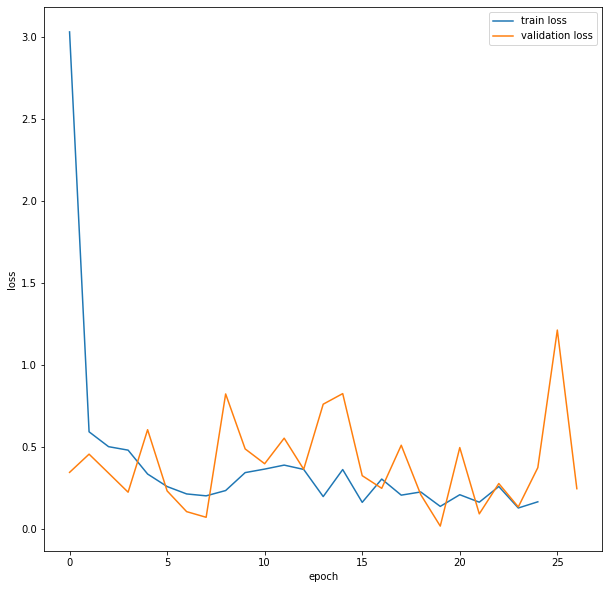

In [ ]:
tloss_plt_epoch = tloss_plt[0::int(epoch_count_train / 50)]
vloss_plt_epoch = vloss_plt[0::int(epoch_count_val / 50)]
print(len(tloss_plt_epoch), len(vloss_plt_epoch))
plt.figure(figsize=[10, 10])
plt.plot(tloss_plt_epoch,label='train loss')
plt.plot(vloss_plt_epoch,label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

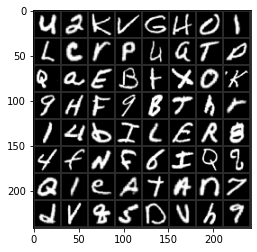

ground truth labels:
    U     2     K     V     G     H     0     I

    L     C     r     P     U     a     T     P

    q     a     E     B     t     X     0     K

    9     H     F     9     B     T     h     r

    1     4     b     I     L     e     R     8

    4     F     N     f     6     I     Q     q

    Q     1     e     A     T     A     n     7

    d     V     q     5     D     V     h     9

predicted:
    U     2     K     V     G     H     O     1

    L     C     r     P     U     a     T     D

    e     a     E     B     t     X     0     K

    9     H     F     9     B     T     h     r

    1     4     b     I     L     E     R     g

    4     f     N     F     8     I     Q     q

    Q     I     e     A     T     A     n     7

    d     V     q     5     D     V     h     9



In [ ]:
valloader_prediction = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

dataiter = iter(valloader_prediction)
images, labels = dataiter.next()

showimg(torchvision.utils.make_grid(images))
print('ground truth labels:')
for k in range(batchrow):
  print(' '.join('%5s' % classes[labels[j]] for j in range(k * 8, (k + 1) * 8)),end='\n\n')
  k += 1

outputs = net(images)

_,predicted = torch.max(outputs, 1)
print('predicted:')
for k in range(batchrow):
  print(' '.join('%5s' % classes[predicted[j]] for j in range(k * 8, (k + 1) * 8)),end='\n\n')
  k += 1

175 175


Text(0, 0.5, 'accuracy,%')

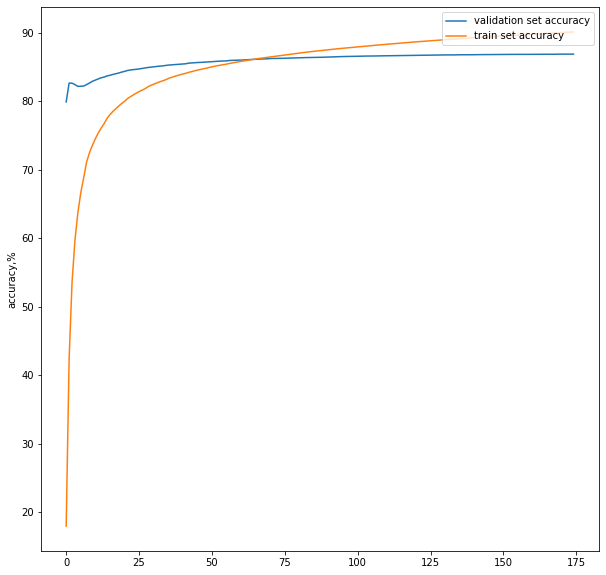

In [ ]:
print(len(train_acc_plot),len(val_acc_plot))
plt.figure(figsize=[10, 10])
plt.plot(val_acc_plot,label='validation set accuracy')
plt.plot(train_acc_plot,label='train set accuracy')
plt.legend(loc='upper right')
plt.ylabel('accuracy,%')

In [ ]:
correct_val = 0
total_val = 0
avg_val_acc = 0.0
avg_loss_val = 0.0

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net(images)

        _, predicted_val = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val == labels).sum().item()
        avg_val_acc = 100 * correct_val / total_val

print('validation accuracy %.2f %%, error rate %.2f %%' % (avg_val_acc, 100 - avg_val_acc))

validation accuracy 87.37 %, error rate 12.63 %


In [ ]:
correct_test = 0
total_test = 0
avg_test_acc = 0.0
avg_loss_test = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()
        avg_test_acc = 100 * correct_test / total_test

print('test accuracy %.2f %%, error rate %.2f %%' % (avg_test_acc, 100 - avg_test_acc))

test accuracy 87.11 %, error rate 12.89 %


version-batchsize-epochnum-lr-dropout-error

1-32-15-0.0005-no-13.77%

2-32-30-0.001-no-14.26%

3-64-15-0.0005-no-13.02%

4-128-15-0.0005-no-13.17%

5-64-15-0.0005-init-13.11%

6-64-30-0.0005-no-14.06%

7-64-10-0.0005-no-12.76%

##things to do:

figure out how to train on gpu!!

use validation and learning curves to evaluate the model

try different hyperparameters, otimizers

if its poor(test accuracy < 90-95%), adjust

overfitting -> add regularization

underfitting -> add more layers

if its still poor, rethink architecture

when its good, try dataset with more classes

bonus: check how do kernels look
